# Elastic-Cracked Shear Field Theory

Introduction to `sympy`, `numpy` and `scipy` to write semi-analytical models for the reinforced cross-sectional combinations.

This notebook rephrases the derivation of the relation between the horizontal and vertical strain component within a shear zone with the goal to derive the inclination angle of the compressive strut.

## Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()

# Symbols

In [2]:
f_c = sp.Symbol('f_c', real=True, nonpositive=True)
f_cref = sp.Symbol('f_{\mathrm{c,ref}}', real=True, nonpositive=True) 

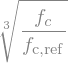

In [3]:
eta_cc = (f_c / f_cref)**sp.Rational(1,3) 
eta_cc

In [4]:
f_cp = sp.Symbol('f_cp')

**Principal strains** $\varepsilon_1$ is a tensile strain lateral to the crack direction and $\varepsilon_3$ is the principal compressive strain in the concrete strut. 

In [5]:
epsilon_1, epsilon_3 = sp.symbols(r'\varepsilon_1, \varepsilon_3')

**Strength reduction factor** is used to reduce the compressive strength of concrete upon lateral tension with the principal tensile strain $\varepsilon_1$

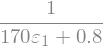

In [6]:
eta_eps = 1 / (0.8 + 170 * epsilon_1)
eta_eps

**Stress variables** in concrete and in reinforcement.
$\sigma_c$ represents the compressive stress in the compression chord

In [7]:
sigma_c = sp.Symbol(r'sigma_c')
sigma_rx = sp.Symbol(r'sigma_rx')
sigma_rz = sp.Symbol(r'sigma_rz')

**Inclination angles** - they are assumed identical later on

In [8]:
theta_sigma, theta_epsilon = sp.symbols(r'\theta_{\sigma},\theta_{\epsilon}')

**Effective reinforcement ratio**

In [9]:
rho_rx_eff = sp.Symbol(r'\rho_{rx,\mathrm{eff}}', nonnegative=True)
rho_rz_eff = sp.Symbol(r'\rho_{rz,\mathrm{eff}}', nonnegative=True)

**Stress transformation**
Transform the stress components oriented in the strut direction to the global stress variables (tensor transformation)

In [10]:
sigma_x = sigma_c * sp.cos(theta_sigma)**2 + rho_rx_eff * sigma_rx
sigma_z = sigma_c * sp.sin(theta_sigma)**2 + rho_rz_eff * sigma_rz
tau_xz = - sigma_c * sp.sin(theta_sigma) * sp.cos(theta_sigma)

**Reinforcement parameters**
There parameters affect the reinforcement ratio

In [11]:
b_w = sp.symbols('b_w')
k_ex, a_rx, n_lx, s_rx = sp.symbols('k_ex, a_rx, n_lx, s_rx')
k_ez, a_rz, n_lz, s_rz = sp.symbols('k_ez, a_rz, n_lz, s_rz')

In [12]:
subs_rho_r_eff = {
    rho_rx_eff : k_ex * a_rx * n_lx / (s_rx * b_w),
    rho_rz_eff : k_ez * a_rz * n_lz / (s_rz * b_w)
}

# Strain compatibility

**Global strain variables**

In [13]:
epsilon_x = sp.Symbol('epsilon_x')
epsilon_z= sp.Symbol('epsilon_z', positive=True)
gamma_xz = sp.Symbol('gamma_xz')

**Compatibility equations**

In [14]:
eps_x = epsilon_x - epsilon_1 * sp.sin(theta_epsilon)**2 + epsilon_3 * sp.cos(theta_epsilon)**2
eps_z = epsilon_z - epsilon_1 * sp.cos(theta_epsilon)**2 + epsilon_3 * sp.sin(theta_epsilon)**2
g_xz = gamma_xz - 2 * (epsilon_1 - epsilon_3) * sp.sin(theta_epsilon) * sp.cos(theta_epsilon)

**Principal strains**
Express the principle strains in terms of global strains and inclination angle

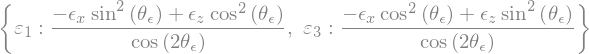

In [15]:
subs_eps_13 = sp.solve({eps_x, eps_z}, [epsilon_1, epsilon_3])
subs_eps_13

Applying the goniometric dependency
\begin{align}
\sin^2(\theta) = \frac{\tan^2(\theta)}{1 + \tan^2(\theta)}
\end{align}
we can rewrite this relation in a simpler way

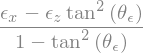

In [16]:
eps_3_from_kinematics = (epsilon_x - epsilon_z * sp.tan(theta_epsilon)**2) / (1 - sp.tan(theta_epsilon)**2)
eps_3_from_kinematics

**Constitutive laws**
are assumed linear elastic

In [17]:
E_c, E_rx, E_rz = sp.symbols('E_c, E_rx, E_rz', nonnegative=True)

In [18]:
subs_sigma = {
    sigma_c : E_c * epsilon_3,
    sigma_rx : E_rx * epsilon_x,
    sigma_rz : E_rz * epsilon_z
}

**Equilibrium condition**
The angle condition is derived with the assumption that $\sigma_z = 0$

In [19]:
sigma_z

Substitute the constitutive law

In [20]:
sigma_z_eps = sigma_z.subs(subs_sigma).subs(theta_sigma, theta_epsilon)
sigma_z_eps

Express the principal compressive strain

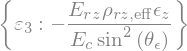

In [21]:
subs_eps_3 = sp.solve({sigma_z_eps}, [epsilon_3])
subs_eps_3

Substitute sin with tan

In [22]:
subs_sin_tan = {
    sp.sin(theta_epsilon)**2: sp.tan(theta_epsilon)**2 / (1 + sp.tan(theta_epsilon)**2) 
}

To reduce the number of parameters introduce the ratio between reinforcement and concrete stiffness

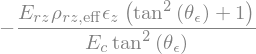

In [23]:
eps_3_from_equilib = subs_eps_3[epsilon_3].subs(subs_sin_tan)
eps_3_from_equilib

In [24]:
alpha_rz = sp.Symbol('alpha_rz')

Require that $\varepsilon_3$ is equal for both the equilibrium $\sigma_z = 0$ and for the compatibility condition

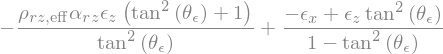

In [25]:
compatibility_eq = eps_3_from_equilib - eps_3_from_kinematics
compatibility_eq_alpha = compatibility_eq.subs(E_rz / E_c, alpha_rz)
compatibility_eq_alpha

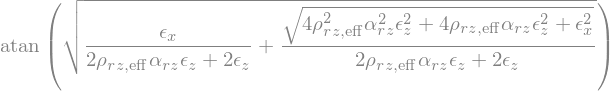

In [26]:
theta_eps = sp.solve(compatibility_eq_alpha, theta_epsilon)
theta_eps[3]

# Plot the results

In [27]:
subs_params = {
#    alpha_rz : 1.5,
#    rho_rz_eff : 0.03,
    epsilon_z : 1
}

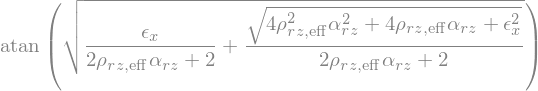

In [28]:
theta_eps_example = theta_eps[3].subs(subs_params)
theta_eps_example

In [29]:
get_theta_eps_x = sp.lambdify((epsilon_x, rho_rz_eff, alpha_rz), theta_eps_example, 'numpy' )

**Plot the inclination angle**

In [30]:
def plot_inclination_angle(alpha_rz):
    eps_min, eps_max = -2, 2
    fig, ax1 = plt.subplots(1,1, figsize=(8,5)) 
    eps_data = np.linspace(eps_min, eps_max, 1000)
    ax1.plot(eps_data, get_theta_eps_x(eps_data, 0.03, alpha_rz),
             color='black', label=r'$\rho$ = 3.0%')
    ax1.fill_between(eps_data, get_theta_eps_x(eps_data, 0.03, alpha_rz),
                     color='black', alpha=0.1)
    ax1.plot(eps_data, get_theta_eps_x(eps_data, 0.015, alpha_rz),
             color='orange', label=r'$\rho$ = 1.5%')
    ax1.plot(eps_data, get_theta_eps_x(eps_data, 0.005, alpha_rz),
             color='green', label=r'$\rho$ = 0.5%')
    ax1.set_xlabel(r'$\varepsilon_x/\varepsilon_z\;\;\mathrm{[-]}$'); ax1.set_ylabel(r'$\theta_\varepsilon\;\;\mathrm{[\pi]}$'); 
    ax1.set_title('inclination of compression field');
    ax1.legend()

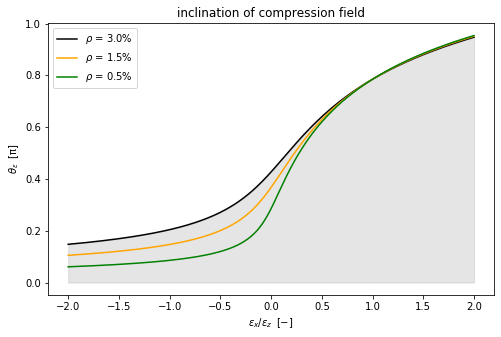

In [31]:
plot_inclination_angle(1.5)

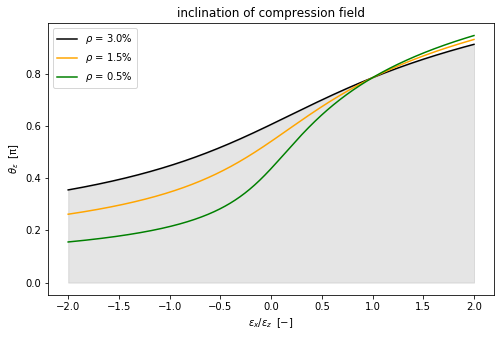

In [32]:
plot_inclination_angle(10)

In [33]:
V = sp.Symbol('V')
M = sp.Symbol('M')
z, b_w = sp.symbols('z, b_w', positive=True)

In [34]:
A_l_eff = sp.Symbol(r'A_{l, \mathrm{eff}}', positive=True)
E_l = sp.Symbol(r'E_{l}', positive=True)

In [35]:
shear_eq = tau_xz * (z * b_w) - V 
shear_eq_eps = shear_eq.subs(theta_sigma, theta_epsilon).subs(subs_sigma)

In [36]:
epsilon_x_kinem = sp.solve(epsilon_3 - eps_3_from_kinematics, epsilon_x)[0]
epsilon_x_kinem

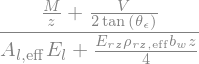

In [37]:
epsilon_l_equilib = (
    M / z + V / sp.tan(theta_epsilon) / 2
) / (
    A_l_eff * E_l + rho_rz_eff / 4 * E_rz * b_w * z
)
epsilon_l_equilib

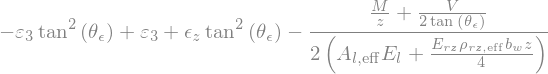

In [38]:
epsilon_x_kinem - epsilon_l_equilib / 2